In [214]:
import numpy as np
import pandas as pd
# %matplotlib widget
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import linear_model, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
import optuna

from zipfile import ZipFile
import pickle

from typing import Callable, Tuple

In [128]:
# some useful functions
def pwn(a: str) -> Callable:
    '''prints parameter a with name'''
    return print(a, '=', eval(a))

### COLLECT DATA

In [129]:
# Read data
with ZipFile('data/data.zip') as myzip:
    X = np.load(myzip.open('X_train.npy'))
    y = pd.read_csv(myzip.open('y_train.csv'))

print(f'X data - sensors {X.shape}, y data - protocol {y.shape}')

X data - sensors (323, 40, 100), y data - protocol (32300, 2)


In [130]:
SAMP = X.shape[0]  # samples in the data
SENS = X.shape[1]  # number of sensors
TICKS = X.shape[2]  # time ticks at one sample
SMINI = 5  # time ticks at one minisample - parameter of our model - "time window"
pwn('SAMP')
pwn('SENS')
pwn('TICKS')
pwn('SMINI')

SAMP = 323
SENS = 40
TICKS = 100
SMINI = 5


In [131]:
# Let's reshape X data into one flow of 40 sensors along the timeline
X_flow = X.transpose(0, 2, 1).reshape((SAMP * TICKS, SENS))
X_flow = pd.DataFrame(X_flow, columns=[f'sens_{s}' for s in range(SENS)])
pwn('X_flow.shape')

X_flow.shape = (32300, 40)


In [132]:
# Check that every column contains data of one sensor, even at the boundary of samples
X_flow.iloc[296:304]

,sens_0,sens_1,sens_2,sens_3,sens_4,sens_5,sens_6,sens_7,sens_8,sens_9,...,sens_30,sens_31,sens_32,sens_33,sens_34,sens_35,sens_36,sens_37,sens_38,sens_39
296,1024.0,13.0,1514.0,27.0,27.0,1475.0,150.0,10.0,1201.0,12.0,...,1902.0,74.0,18.0,1250.0,128.0,33.0,1625.0,32.0,872.0,22.0
297,1019.0,12.0,1511.0,48.0,27.0,1471.0,151.0,3.0,1200.0,11.0,...,1902.0,71.0,24.0,1246.0,129.0,32.0,1626.0,27.0,872.0,24.0
298,1018.0,0.0,1507.0,48.0,25.0,1469.0,151.0,6.0,1195.0,12.0,...,1902.0,72.0,22.0,1247.0,124.0,33.0,1628.0,21.0,875.0,26.0
299,1013.0,10.0,1506.0,51.0,29.0,1465.0,149.0,8.0,1179.0,11.0,...,1901.0,72.0,17.0,1250.0,123.0,33.0,1628.0,26.0,870.0,26.0
300,1011.0,14.0,1499.0,52.0,17.0,1459.0,152.0,1.0,1185.0,10.0,...,1901.0,70.0,17.0,1231.0,128.0,33.0,1626.0,24.0,869.0,25.0
301,1009.0,0.0,1495.0,45.0,26.0,1455.0,142.0,8.0,1184.0,6.0,...,1903.0,70.0,17.0,1247.0,124.0,33.0,1627.0,26.0,869.0,25.0
302,1008.0,16.0,1495.0,54.0,29.0,1452.0,150.0,4.0,1184.0,9.0,...,1904.0,68.0,14.0,1246.0,126.0,33.0,1626.0,37.0,866.0,25.0
303,1009.0,13.0,1511.0,50.0,27.0,1452.0,152.0,6.0,1179.0,10.0,...,1908.0,64.0,19.0,1247.0,128.0,33.0,1628.0,24.0,864.0,26.0


In [133]:
y.tail()

,sample-timestep,class
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4
32299,322-99,4


`y_train.csv` includes the following commands: 
  - `0` - "open";
  - `1` - "bend little finger";
  - `2` - "bend ring finger";
  - `3` - "bend middle finger";
  - `4` - "bend gesture gun";
  - `5` - "bend index finger";
  - `6` - "bend thumb";
  - `7` - "bend gesture ОК";
  - `8` - "bend gesture grab";

Additionally it contains 'sample-timestep' feature that we can divide into two columns for further work.

In [134]:
# Create gestures dictionary
GEST = {
    0: "open",
    1: "little",
    2: "ring",
    3: "middle",
    4: "gun",
    5: "index",
    6: "thumb",
    7: "ОК",
    8: "grab",
}

In [135]:
# Aggregate X and y data into one DF for the following EDA
y['sample'] = y['sample-timestep'].apply(lambda x: int(x.split('-')[0]))
y['timestamp'] = y['sample-timestep'].apply(lambda x: int(x.split('-')[1]))


X_df = X_flow.join(y).drop('sample-timestep', axis=1).rename(columns={'class': 'command'})
X_df.tail()

,sens_0,sens_1,sens_2,sens_3,sens_4,sens_5,sens_6,sens_7,sens_8,sens_9,...,sens_33,sens_34,sens_35,sens_36,sens_37,sens_38,sens_39,command,sample,timestamp
32295,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0,4,322,95
32296,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0,4,322,96
32297,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0,4,322,97
32298,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0,4,322,98
32299,1666.0,8.0,1829.0,36.0,26.0,2245.0,41.0,8.0,1363.0,0.0,...,1198.0,102.0,25.0,1691.0,22.0,398.0,26.0,4,322,99


### EDA

In [136]:
# Check that all columns are numerical only and have no data missing
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32300 entries, 0 to 32299
Data columns (total 43 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sens_0     32300 non-null  float64
 1   sens_1     32300 non-null  float64
 2   sens_2     32300 non-null  float64
 3   sens_3     32300 non-null  float64
 4   sens_4     32300 non-null  float64
 5   sens_5     32300 non-null  float64
 6   sens_6     32300 non-null  float64
 7   sens_7     32300 non-null  float64
 8   sens_8     32300 non-null  float64
 9   sens_9     32300 non-null  float64
 10  sens_10    32300 non-null  float64
 11  sens_11    32300 non-null  float64
 12  sens_12    32300 non-null  float64
 13  sens_13    32300 non-null  float64
 14  sens_14    32300 non-null  float64
 15  sens_15    32300 non-null  float64
 16  sens_16    32300 non-null  float64
 17  sens_17    32300 non-null  float64
 18  sens_18    32300 non-null  float64
 19  sens_19    32300 non-null  float64
 20  sens_2

In [137]:
# Some statistics of sensors
pwn('X_flow.describe().loc["min"].min()')
pwn('X_flow.describe().loc["max"].max()')
pwn('X_flow.describe().loc["std"].max()')
pwn('(X_flow.describe().loc["std"] / (X_flow.describe().loc["max"] - X_flow.describe().loc["min"])).max()')
pwn('(X_flow.describe().loc["mean"] - X_flow.describe().loc["50%"] >= 0).sum()')
X_flow.describe()

X_flow.describe().loc["min"].min() = 0.0
X_flow.describe().loc["max"].max() = 3705.0
X_flow.describe().loc["std"].max() = 535.6757847555185


(X_flow.describe().loc["std"] / (X_flow.describe().loc["max"] - X_flow.describe().loc["min"])).max() = 0.24032112371265973
(X_flow.describe().loc["mean"] - X_flow.describe().loc["50%"] >= 0).sum() = 34


,sens_0,sens_1,sens_2,sens_3,sens_4,sens_5,sens_6,sens_7,sens_8,sens_9,...,sens_30,sens_31,sens_32,sens_33,sens_34,sens_35,sens_36,sens_37,sens_38,sens_39
count,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,...,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000
mean,1080.010031,10.248885,1282.964737,28.563994,23.041269,1572.169876,66.113344,6.691146,976.046873,11.724768,...,1449.424180,69.892291,14.287523,1151.938607,116.753746,24.823746,1741.236378,25.751517,522.477276,23.774241
std,298.128816,6.506902,437.590318,15.733459,7.911239,497.383955,29.852017,4.701581,247.630096,4.357266,...,535.675785,8.076322,5.161231,61.085345,17.736049,4.121546,136.014045,5.689679,165.799217,4.021698
min,538.000000,0.000000,492.000000,0.000000,0.000000,662.000000,15.000000,0.000000,518.000000,0.000000,...,870.000000,3.000000,0.000000,1014.000000,66.000000,3.000000,1362.000000,0.000000,249.000000,0.000000
25%,834.000000,6.000000,993.000000,18.000000,17.000000,1172.000000,41.000000,4.000000,770.000000,9.000000,...,1039.000000,65.000000,11.000000,1103.000000,105.000000,22.000000,1638.000000,23.000000,384.000000,22.000000
50%,1019.000000,10.000000,1230.500000,26.000000,22.000000,1542.000000,53.000000,6.000000,971.000000,11.000000,...,1275.000000,70.000000,14.000000,1140.000000,118.000000,24.000000,1735.000000,26.000000,465.000000,23.000000
75%,1297.000000,14.000000,1460.000000,35.000000,28.000000,1924.000000,91.000000,9.000000,1162.000000,14.000000,...,1753.000000,74.000000,17.000000,1198.000000,130.000000,27.000000,1856.000000,28.000000,629.000000,25.000000
max,2098.000000,72.000000,2715.000000,178.000000,66.000000,3109.000000,160.000000,56.000000,1597.000000,34.000000,...,3099.000000,138.000000,59.000000,1350.000000,171.000000,50.000000,2105.000000,81.000000,965.000000,46.000000


All sensors data are positive and less than 4 000.

Stds are not more than 25% of sensor maximum value minus minimum value.

Only 6 sensors have median higher than mean value. We could suppose that these sensors mostly move down from the "neutral" gesture "open".

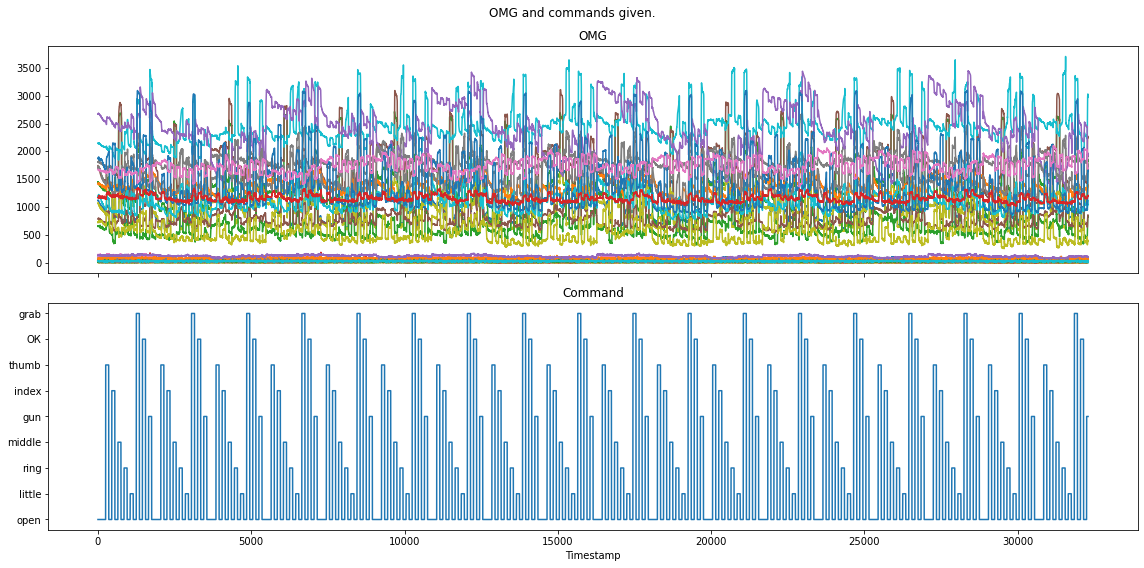

In [138]:
def plot_omg_and_commands(omg: pd.DataFrame, commands: pd.Series, classes: pd.Series=None, i: int=None) -> None:
    """Plot omg data at one subplot and command labels below

    Args:
        omg (pd.DataFrame): omg data.
        commands (pd.Series): commands labels.
        classes (pd.Series, optional): classes labels could be added. Defaults to None.
        i (int, optional): number of sample plotted. Defaults to None.
    """
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
        
    axx[0].plot(omg)
    axx[0].set_title('OMG')

    axx[1].plot(commands)
    if classes is not None:
        axx[1].plot(classes)
        axx[1].set_title('Command / Gesture')
        stitle = 'OMG, commands given and gestures predicted.'
    else:    
        axx[1].set_title('Command')
        stitle = 'OMG and commands given.'
    axx[1].set_xlabel('Timestamp')
    axx[1].set_yticks(list(GEST.keys()), labels=list(GEST.values()))
    
    if i:
        stitle += f' SAMPLE {i}'
    plt.suptitle(stitle)
    plt.tight_layout()
    plt.show();


# Plot all data
plot_omg_and_commands(X_flow, X_df['command'])

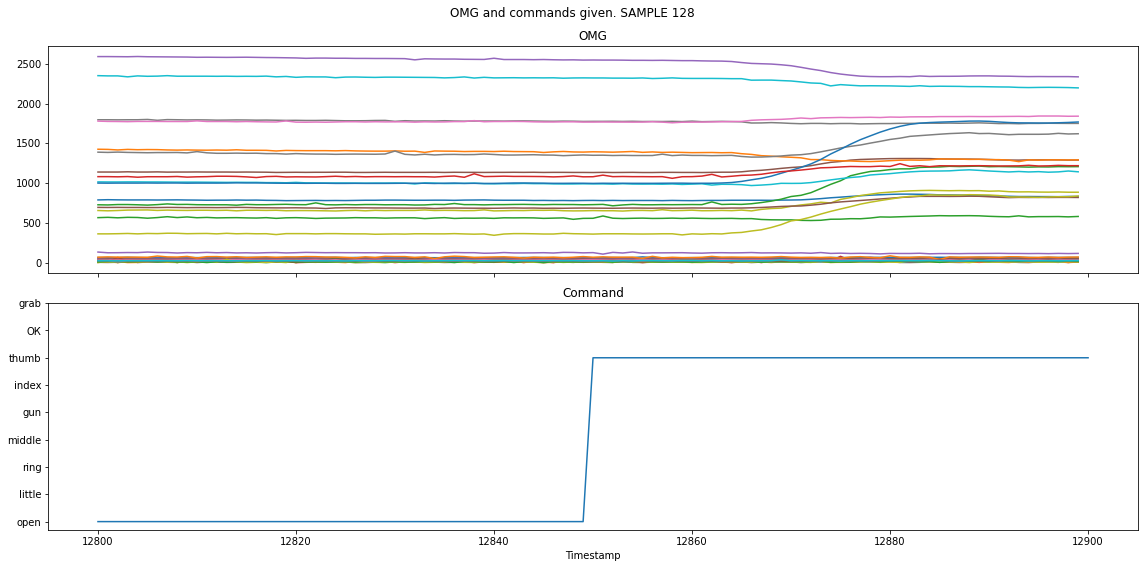

In [139]:
# Plot one random sample to see how sensors follow the command given
i = np.random.randint(SAMP)
plot_omg_and_commands(X_flow.iloc[TICKS*i:TICKS*(i+1)], X_df.loc[TICKS*i:TICKS*(i+1), 'command'], i=i)

## **PROBLEM EXPLANATION**
The figure above exhibits the main difficulty in the problem. We have no real "target" to train the model. The Y-data contains a protocol for data production that works at the following schema.

OMG-sensors are fixed at a pilot wrist. The pilot gets a visual command to perform a gesture at the moment when the command label changes in the protocol.

OMG-sensors change later in the process of the gesture being performed by the pilot.

So, we have a transit zone consisting of two time intervals:
- the pilot sees the command and prepares to perform the gesture (here, the command and gesture labels do not coinside because the command label has already changed but the pilot still hasn't started performing the gesture);
- the pilot is performing the gesture (at some moment of this interval the gesture label changes from the old to the actual label, and we hope it again coincides with the command label).

Thus, the problem is divided into two parts:
1. to construct a target label that coincides with the gesture at every time moment, meaning we have to find the very moment of the gesture change;
2. to train a model to predict gesture labels relying on the target from the step 1.

Outside of the scope of this notebook, it was shown that the moment of the gesture change couldn't be revealed at a narrow time window (5 time ticks) with mathematical models such as derivative analysis, crosspoint of different moving averages and so on without "looking into the future".

## **Main hypothesis** of this work

If we train a model on the "clear" gestures - the part of the data outside of the transit zone - the model would be able to predict the gradual shift of probabilities from the class corresponding to the gesture before movement to the class after movement. This would allow us to predict the moment of the gesture change.

In [140]:
# To visualise the length of the transit zone and which sensors are involved in which gesture 
# let's construct X_diff where the mean sensor data from the first half of every sample is subtracted from all sensor data in the sample
X_diff = X_df.copy()
# mark the second half of every sample as -1 to exclude from means
X_diff.loc[(X_diff.index % TICKS) > (TICKS / 2), 'sample'] = -1
# get mean data of the first half of every sample
X_start_means = X_diff[X_diff['sample'] != -1].groupby(by='sample')[[f'sens_{s}' for s in range(SENS)]].mean()
# and propagate to X_diff timestamps
X_start_means = X_start_means.loc[X_start_means.index.repeat(TICKS)].reset_index(drop=True)
# substruct 'the first halves means' from the every timestamp data
X_diff[[f'sens_{s}' for s in range(SENS)]] = X_diff[[f'sens_{s}' for s in range(SENS)]] - X_start_means

# add to every row the label 'gesture at the begin - gesture at the end'
y_begin = y.loc[y.index % TICKS == 0]['class'].astype(str).reset_index(drop=True)
y_end = y[(y.index % TICKS) == (TICKS - 1)]['class'].astype(str).reset_index(drop=True)
y_be = y_begin + '-' + y_end
X_diff['b-e'] = y_be.loc[y_be.index.repeat(TICKS)].reset_index(drop=True)

In [141]:
def plot_diff_heatmaps(row: int, col: int, ax: list) -> None:
    """Plot X_diff cumulative heatmap for row + 1 gesture at [row, col] subplot

    Args:
        row (int): coincides with gesture number - 1
        col (int): 0 - bend gesture (left column), 1 - straighten gesture (right column)
        ax (list): subplots
    """    
    if col:
        g = f'{i+1}-0'
        tit = f'straighten gesture {GEST[i+1]}'
    else:
        g = f'0-{i+1}'
        tit = f'bend gesture {GEST[i+1]}'
    sns.heatmap(X_diff[X_diff['b-e'] == g].groupby('timestamp')[[f'sens_{s}' for s in range(SENS)]].sum(),
                ax=ax[row, col], cmap='RdYlGn', vmin=-2500, vmax=2500, cbar=False)
    ax[row, col].set_xticks([s for s in range(0, SENS, 2)], labels=[s for s in range(0, SENS, 2)])
    ax[row, col].set_title(tit)

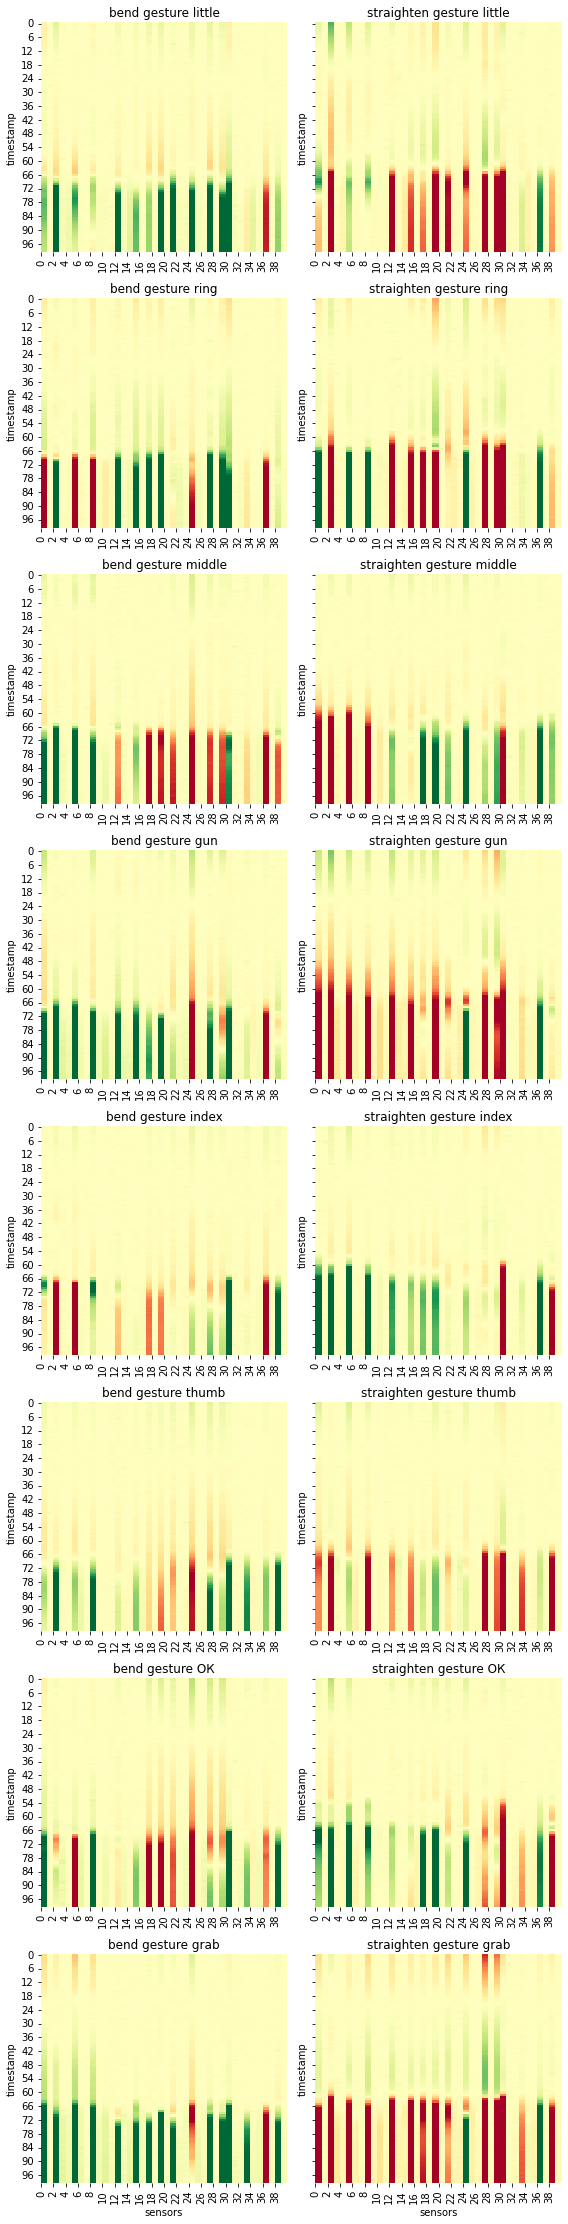

In [142]:
# plot heatmaps to show sensors participating in gestures
# green - sensor values go upper, red - sensor values go lower
fig, ax = plt.subplots(8, 2, sharey=True, figsize=(8, 31))
for i in range(8):
    plot_diff_heatmaps(i, 0, ax)
    plot_diff_heatmaps(i, 1, ax)
ax[7, 0].set_xlabel('sensors')
ax[7, 1].set_xlabel('sensors')
plt.tight_layout()
plt.show();

Now we can state that the transit zone starts at timestamp = 50 and ends to the timestamp = 79.

So, let's consider zones of "clear" gestures - zones where gesture label should coincide with command label. At these parts of data we will train the first model. This model we will use later to get target for the main model.

In [143]:
clear_indexes = np.array([[s*TICKS + i for i in range(4, 50)] + [s*TICKS + i for i in range(83, 100)] for s in range(SAMP)]).reshape(-1)
X_clear = X_df[X_df.index.isin(clear_indexes)].copy()
pwn('X_clear.shape')

X_clear.shape = (20349, 43)


Let's plot range of sensor values at different gestures. We will take two sensors #30 and #36 because they take part in all gestures and with different signs.

Additionally we divide all time of data production into three parts:
- begin 
- middle
- end

to reveal whether range of sensor values is stable during the process of data production.

In [144]:
X_clear['period'] = X_clear['sample'].apply(lambda x: 'begin' if x < SAMP / 3 else ('end' if x > SAMP / 3 * 2 else 'middle'))
X_clear['period'].value_counts()

begin     6804
middle    6804
end       6741
Name: period, dtype: int64

In [145]:
def boxplot_clear_gestures(sensor: int, ax: object) -> None:
    """Boxplot distribution of sensor values at different gestures

    Args:
        sensor (int): number of sensor
        ax (list): subplot object
    """    
    sns.boxplot(data=X_clear, x=f'sens_{sensor}', y='command', ax=ax, hue='period', orient='h', 
                            width=0.9, dodge=True, showmeans=True)
    ax.set_ylabel('gesture')
    ax.set_yticks(list(GEST.keys()), labels=list(GEST.values()))

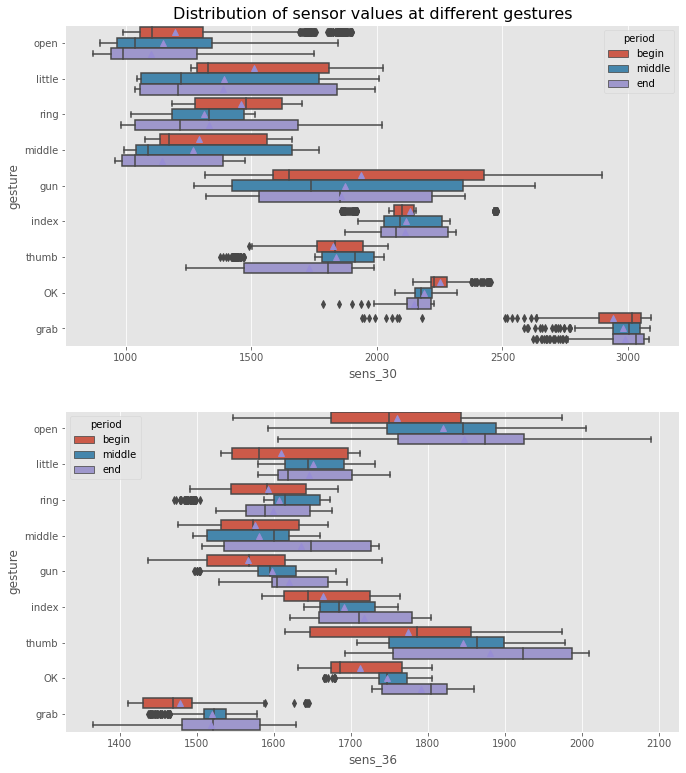

In [146]:
plt.style.use('ggplot')
fig, ax = plt.subplots(2, figsize=(11, 13))
for s in (0, 1):
    boxplot_clear_gestures((30, 36)[s], ax[s])
ax[0].set_title(f'Distribution of sensor values at different gestures', fontsize=16)
plt.tight_layout
plt.show;

Boxplots shows that sensors has different characteristic levels for different gesture. But:
- levels overlap each other,
- levels could shift during time of data production.

Thus we need sophisticated model that takes into account more than some sensors.

### MODEL #1 TRAINING

As we can see at the plot of all data the protocol pattern repeats almost 18 times at our dataset. Let's take 14 patterns as train part of the data. It is about 78%. And the rest we will use as validation set.

We should find the minimum index of 15-th repeat of the pattern that starts from '0-0' transition (no any gesture is performed). All data below this index - train set and this index and above - validation set.

In [147]:
train_ind = X_diff[(X_diff['b-e'] == '0-0')&(X_diff['sample'] > 14*18 - 3)&(X_diff['sample'] < 14*18 + 3)]['sample'].index.min()
pwn('train_ind')

train_ind = 25200


In [148]:
X_df_train = X_df[X_df.index < train_ind].drop(['command', 'sample', 'timestamp'], axis=1)
X_df_val = X_df[X_df.index >= train_ind].drop(['command', 'sample', 'timestamp'], axis=1)
y_df_train = X_df[X_df.index < train_ind]['command']
y_df_val = X_df[X_df.index >= train_ind]['command']
X_df_train.shape, X_df_val.shape, y_df_train.shape, y_df_val.shape

((25200, 40), (7100, 40), (25200,), (7100,))

In [149]:
# Sensors are noisy so we will build the model at 5-time ticks window (SMINI = 5)

def window_smini(Xdf: pd.DataFrame, ys: pd.Series, indexes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Makes X as SMINI-time ticks window, reshape to plain 2D-array,
    filter X and y by indexes.

    Args:
        Xdf (pd.DataFrame): DataFrame - source of X-data
        ys (pd.Series): Series - source of y-data
        indexes (np.ndarray): array of indexes to filter X and y from the source

    Returns:
        Tuple[np.ndarray, np.ndarray]: X, y
    """    
    X = np.expand_dims(Xdf[Xdf.index.isin(indexes)].values, axis=2)
    for i in range(1, SMINI):
        X = np.concatenate((X, np.expand_dims(Xdf[Xdf.index.isin(indexes - i)].values, axis=2)), axis=2)
    X = X.reshape((X.shape[0], SMINI * SENS))
    y = ys[ys.index.isin(indexes)].values
    return X, y


X_cw_train, y_cw_train = window_smini(X_df_train, y_df_train, clear_indexes)
X_cw_val, y_cw_val = window_smini(X_df_val, y_df_val, clear_indexes)
pwn('X_cw_train.shape')
pwn('y_cw_train.shape')
pwn('X_cw_val.shape')
pwn('y_cw_val.shape')

X_cw_train.shape = (15876, 200)
y_cw_train.shape = (15876,)
X_cw_val.shape = (4473, 200)
y_cw_val.shape = (4473,)


Train the first model that should help us to reveal the moment of gesture change. It will give us the target to train the main model at all train data.

At this step, we do not apply any data standardization or normalization, as doing so would cause a stable shift in the moment of gesture change by approximately two ticks.

In [150]:
lr = linear_model.LogisticRegression(
    multi_class='multinomial',
    max_iter=2000, 
    random_state=42
)
lr.fit(X_cw_train, y_cw_train)

LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=42)

In [151]:
y_cw_train_pred = lr.predict(X_cw_train)
y_cw_val_pred = lr.predict(X_cw_val)
print(metrics.classification_report(y_cw_train, y_cw_train_pred))
print(metrics.classification_report(y_cw_val, y_cw_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8820
           1       1.00      1.00      1.00       882
           2       1.00      1.00      1.00       882
           3       1.00      1.00      1.00       882
           4       1.00      1.00      1.00       882
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       882
           8       1.00      1.00      1.00       882

    accuracy                           1.00     15876
   macro avg       1.00      1.00      1.00     15876
weighted avg       1.00      1.00      1.00     15876

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2503
           1       0.89      1.00      0.94       252
           2       1.00      1.00      1.00       252
           3       1.00      1.00      1.00       252
           4       1.00 

The model predicts train data with 100% positive result. It means that clear gestures are **linearly separable**.

At the validation dataset there was some true "open" that model classified as gesture "bend little finger". We can see below that there are 31 errors at val data.

In [152]:
pwn('y_cw_val[y_cw_val != y_cw_val_pred].shape')
y_cw_val[y_cw_val != y_cw_val_pred]

y_cw_val[y_cw_val != y_cw_val_pred].shape = (31,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Let's try to get better result by selection of hyperparameters.

In [200]:
# function for hyperparameters selection with Optuna
Xopt=X_cw_train
yopt=y_cw_train
solvers_to_check = ['saga', 'lbfgs', 'sag', 'newton-cg']


def optuna_lr1(trial) -> float:
    """Support function for Optuna optimization process to estimate f1-score with cross validation.

    Args:
        trial (method): inner method of study

    Returns:
        float: weighted f1-score
    """     
    solver = trial.suggest_categorical('solver', solvers_to_check)
    C = trial.suggest_float('C', low=10**(-2), high=10**2, log=True)
    # create model
    model = linear_model.LogisticRegression(multi_class='multinomial', C=C, penalty='l2', solver=solver, 
                                            max_iter = 2000, random_state=43)
    # cross validation with 3 folds
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, Xopt, yopt, cv=skf, scoring="f1_weighted", n_jobs=-1).mean()
    return score

In [154]:
# create the study object
study_lr1 = optuna.create_study(study_name="LogisticRegression1", direction="maximize")
# search the best combination of hyperparameters n_trials times
study_lr1.optimize(optuna_lr1, n_trials=10)
print(f"Best hyperparameters: {study_lr1.best_params}")
print(f"f1_score at train data: {study_lr1.best_value:.6f}")

[I 2023-10-04 14:49:17,882] A new study created in memory with name: LogisticRegression1
[I 2023-10-04 14:49:41,197] Trial 0 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.026113974065623907}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 14:49:58,823] Trial 1 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.07942952936970642}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 14:52:43,594] Trial 2 finished with value: 0.9994948763661977 and parameters: {'solver': 'saga', 'C': 0.02270391774247707}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 14:55:44,966] Trial 3 finished with value: 0.9994948763661977 and parameters: {'solver': 'saga', 'C': 28.632172909810723}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 14:58:28,029] Trial 4 finished with value: 0.9995578657997108 and parameters: {'solver': 'sag', 'C': 0.11651874074607123}. Best is trial 0 with value: 

Best hyperparameters: {'solver': 'lbfgs', 'C': 0.026113974065623907}
f1_score at train data: 0.999684


Different combinations of solvers and parameter C give the same result. Could it be better?

In [155]:
study_lr1.optimize(optuna_lr1, n_trials=10)
print(f"Best hyperparameters: {study_lr1.best_params}")
print(f"f1_score at train data: {study_lr1.best_value:.6f}")

[I 2023-10-04 15:08:08,754] Trial 10 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.49341618471285925}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 15:08:29,486] Trial 11 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.014020019834650583}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 15:08:49,336] Trial 12 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.1183119226468553}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 15:09:09,342] Trial 13 finished with value: 0.9996838424805273 and parameters: {'solver': 'lbfgs', 'C': 0.010030396646654048}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 15:10:17,257] Trial 14 finished with value: 0.9996838424805273 and parameters: {'solver': 'newton-cg', 'C': 0.07219447223822889}. Best is trial 0 with value: 0.9996838424805273.
[I 2023-10-04 15:10:36,414] Trial 15 finished with valu

Best hyperparameters: {'solver': 'lbfgs', 'C': 0.026113974065623907}
f1_score at train data: 0.999684


10 more trials give the same stable score estimation.

Apply the best hyperparameters to the postponed validation data.

In [157]:
lr_opt1 = linear_model.LogisticRegression(**study_lr1.best_params, multi_class='multinomial', penalty='l2',
                                            max_iter = 2000, random_state=42)
lr_opt1.fit(X_cw_train, y_cw_train)
y_cw_train_opt = lr_opt1.predict(X_cw_train)
y_cw_val_opt = lr_opt1.predict(X_cw_val)
print(metrics.classification_report(y_cw_train, y_cw_train_opt))
print(metrics.classification_report(y_cw_val, y_cw_val_opt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8820
           1       1.00      1.00      1.00       882
           2       1.00      1.00      1.00       882
           3       1.00      1.00      1.00       882
           4       1.00      1.00      1.00       882
           5       1.00      1.00      1.00       882
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       882
           8       1.00      1.00      1.00       882

    accuracy                           1.00     15876
   macro avg       1.00      1.00      1.00     15876
weighted avg       1.00      1.00      1.00     15876

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2503
           1       0.91      1.00      0.95       252
           2       1.00      1.00      1.00       252
           3       1.00      1.00      1.00       252
           4       1.00 

In [158]:
pwn('y_cw_val[y_cw_val != y_cw_val_opt].shape')
y_cw_val[y_cw_val != y_cw_val_opt]

y_cw_val[y_cw_val != y_cw_val_opt].shape = (24,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

We have 24 errors instead of 31.

Now repeat the best hyperparameters selection at all "clear" gestures.

In [159]:
X_cw = np.vstack((X_cw_train, X_cw_val))
y_cw = np.concatenate((y_cw_train, y_cw_val))
pwn('X_cw.shape')
pwn('y_cw.shape')
Xopt=X_cw
yopt=y_cw

study_lr2 = optuna.create_study(study_name="LogisticRegression2", direction="maximize")
study_lr2.optimize(optuna_lr1, n_trials=10)
print(f"Best hyperparameters: {study_lr2.best_params}")
print(f"f1_score at all data: {study_lr2.best_value:.6f}")

[I 2023-10-04 17:26:41,931] A new study created in memory with name: LogisticRegression2


X_cw.shape = (20349, 200)
y_cw.shape = (20349,)


[I 2023-10-04 17:29:32,273] Trial 0 finished with value: 0.9999016842549407 and parameters: {'solver': 'sag', 'C': 83.66915913475194}. Best is trial 0 with value: 0.9999016842549407.
[I 2023-10-04 17:29:54,402] Trial 1 finished with value: 1.0 and parameters: {'solver': 'lbfgs', 'C': 0.12253571178648476}. Best is trial 1 with value: 1.0.
[I 2023-10-04 17:32:38,573] Trial 2 finished with value: 0.9999016842549407 and parameters: {'solver': 'sag', 'C': 0.039145388016944505}. Best is trial 1 with value: 1.0.
[I 2023-10-04 17:32:52,676] Trial 3 finished with value: 1.0 and parameters: {'solver': 'newton-cg', 'C': 0.3426486210969454}. Best is trial 1 with value: 1.0.
[I 2023-10-04 17:33:15,408] Trial 4 finished with value: 1.0 and parameters: {'solver': 'lbfgs', 'C': 0.5915915598730774}. Best is trial 1 with value: 1.0.
[I 2023-10-04 17:33:38,116] Trial 5 finished with value: 1.0 and parameters: {'solver': 'lbfgs', 'C': 0.03945290649829625}. Best is trial 1 with value: 1.0.
[I 2023-10-04 17

Best hyperparameters: {'solver': 'lbfgs', 'C': 0.12253571178648476}
f1_score at all data: 1.000000


At the whole "clear" gesture dataset solver 'lbfgs' provides 100% result that doesn't depend on parameter C at the wide range. The same result we got at train-test analysis, therefore we can say that there is no place for overfitting. 

So, let's take for our Model #1 solver = 'lbfgs' and C = 1 that corresponds the default parameters.

In [172]:
lr_opt = linear_model.LogisticRegression(multi_class='multinomial', max_iter = 2000, random_state=42)
lr_opt.fit(X_cw, y_cw)
y_cw_opt = lr_opt.predict(X_cw)
print(metrics.classification_report(y_cw, y_cw_opt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11323
           1       1.00      1.00      1.00      1134
           2       1.00      1.00      1.00      1134
           3       1.00      1.00      1.00      1134
           4       1.00      1.00      1.00      1088
           5       1.00      1.00      1.00      1134
           6       1.00      1.00      1.00      1134
           7       1.00      1.00      1.00      1134
           8       1.00      1.00      1.00      1134

    accuracy                           1.00     20349
   macro avg       1.00      1.00      1.00     20349
weighted avg       1.00      1.00      1.00     20349



In [173]:
pwn('y_cw[y_cw != y_cw_opt].shape')
y_cw[y_cw != y_cw_opt]

y_cw[y_cw != y_cw_opt].shape = (0,)


array([], dtype=int64)

Now we have obtained the good working model and can apply it to the whole dataset to produce a target array.

In [29]:
# train and val data with 5-ticks sliding window
X_train, _ = window_smini(X_df_train, y_df_train, X_df_train[SMINI-1:].index)
X_val, _ = window_smini(X_df_val, y_df_val, X_df_val[SMINI-1:].index)
pwn('X_train.shape')
pwn('X_val.shape')

X_train.shape = (25196, 200)
X_val.shape = (7096, 200)


In [174]:
# predict for train and val data
y_train = lr_opt.predict(X_train)
y_val = lr_opt.predict(X_val)
y_train_prob = np.round(lr_opt.predict_proba(X_train), 2)
y_val_prob = np.round(lr_opt.predict_proba(X_val), 2)
pwn('y_train.shape')
pwn('y_val.shape')
pwn('y_train_prob.shape')
pwn('y_val_prob.shape')

y_train.shape = (25196,)
y_val.shape = (7096,)
y_train_prob.shape = (25196, 9)
y_val_prob.shape = (7096, 9)


### MODEL #1 RESULT ESTIMATION

We remember that in the first part we do not have a classic supervised learning problem. Therefore, we need to:

- estimate the results of Model #1,
- correct them to obtain the best target for the next model

In [175]:
# add all data received to dataframe
y_targ = np.concatenate((np.repeat(y_train[0], 4), y_train, np.repeat(y_val[0], 4), y_val))
y_targ_prob = np.concatenate((np.repeat(y_train_prob[0:1], 4, axis=0), y_train_prob, np.repeat(y_val_prob[0:1], 4, axis=0), y_val_prob))
X_df['target'] = y_targ
target_prob = pd.DataFrame(y_targ_prob, index=X_df.index)
print('Model predicts transit zones within boundaries:')
X_df[X_df['target'] != X_df['command']]['timestamp'].min(), X_df[X_df['target'] != X_df['command']]['timestamp'].max()

Model predicts transit zones within boundaries:


(50, 81)

As expected the model works without errors at the parts out of transit zone.

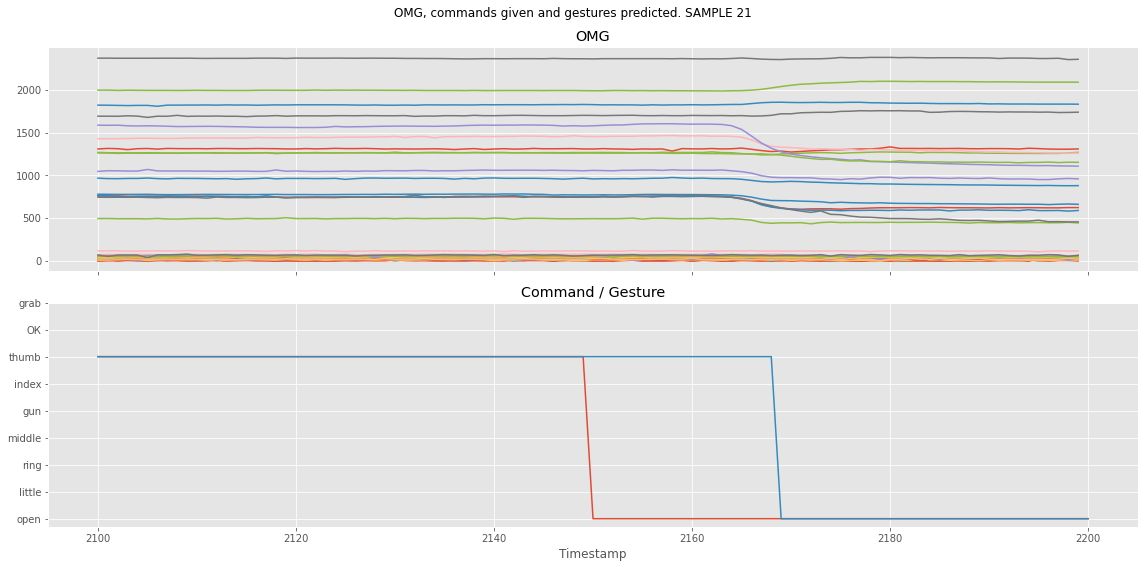

In [176]:
# Plot one random sample to see how predicted moment of the gesture change shifted from the command given
i = np.random.randint(SAMP)
plot_omg_and_commands(X_flow.iloc[TICKS*i:TICKS*(i+1)], X_df.loc[TICKS*i:TICKS*(i+1), 'command'], 
                      X_df.loc[TICKS*i:TICKS*(i+1), 'target'], i=i)

Visualization gives us understanding of imperfections within transit zones.

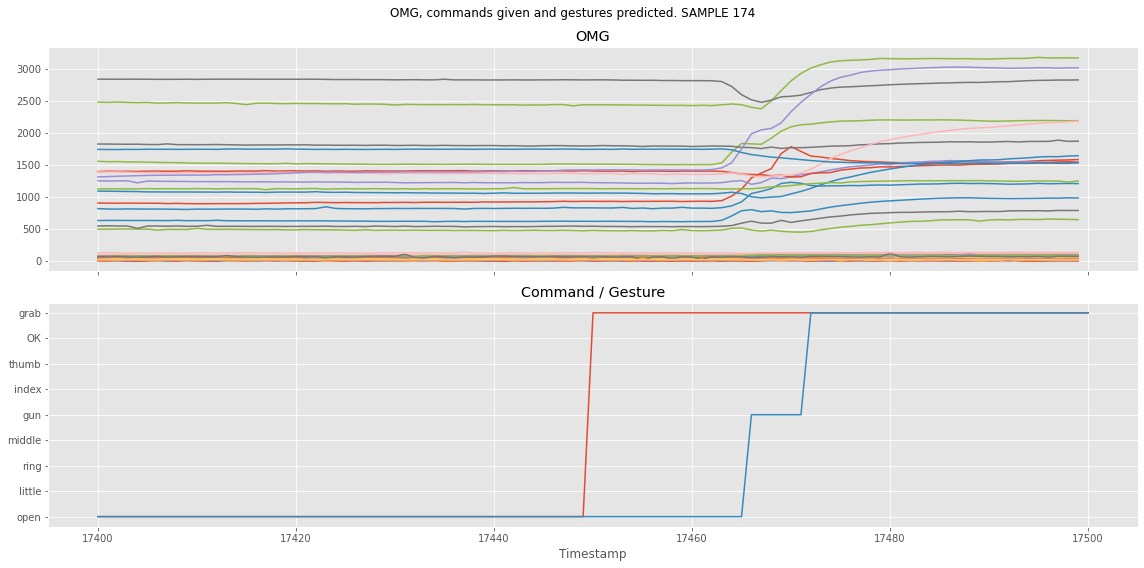

In [177]:
# Plot for example sample #174 where transit zone is not perfect: 
# between "open" and "ring finger" the model predicted some ticks of "little finger"
i = 174
plot_omg_and_commands(X_flow.iloc[TICKS*i:TICKS*(i+1)], X_df.loc[TICKS*i:TICKS*(i+1), 'command'], 
                      X_df.loc[TICKS*i:TICKS*(i+1), 'target'], i=i)

If we take a look into probabilities of this transit zone we can see that the pilot's palm was open at the begin. Then the pilot started to bend 3-4-5 fingers and only after 6 time ticks the pilot's palm formed the gesture "grab" that correspondes with the command given.

In [178]:
# Rows of gestures with non-zero probabilities
target_prob.iloc[17460:17478][[0, 4, 8]].T.iloc[::-1]

,17460,17461,17462,17463,17464,17465,17466,17467,17468,17469,17470,17471,17472,17473,17474,17475,17476,17477
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.22,0.84,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.97,0.78,0.16,0.0,0.0,0.0,0.0,0.0
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


We can say that it is consequence of the pilot's imperfections at gestures execution and let it be.

But we will change all imperfect labels into the labels of the gesture after the movement. This processing is needed to avoid any "intermediate" class in transit zone. That is to avoid predicts like

0,0,0,0,0,4,4,4,4,4,4,8,8,8,8 .

We want to explain the model that despite of these combinations of sensors values looks like #4-th gesture, they should be classified as gesture #8.

In [179]:
X_df['b_e'] = X_diff['b-e']
X_df['imperf'] = X_df.apply(lambda x: 1 if (x.target != int(x.b_e.split('-')[0])) and
                            (x.target != int(x.b_e.split('-')[1])) else 0, axis=1)
f"Number of imperfect labels: {X_df['imperf'].sum()}"

'Number of imperfect labels: 385'

In [180]:
f"Samples with imperfect transit zone: {X_df[X_df['imperf'] == 1]['sample'].nunique()}"

'Samples with imperfect transit zone: 129'

In [181]:
# Make generator of samples with imperfect transit zones to visualize them
X_df['targ_change'] = X_df['target'].diff()
imperf_samp = iter(X_df[X_df['targ_change'] != 0].groupby(by='sample')['targ_change'].count().sort_values(ascending=False).index)

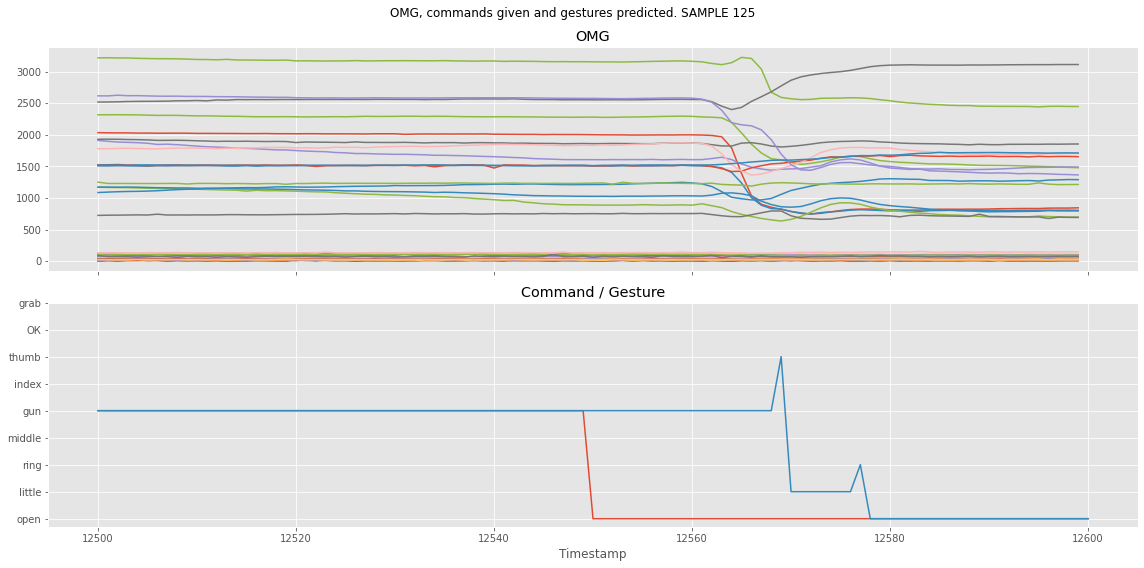

,12560,12561,12562,12563,12564,12565,12566,12567,12568,12569,12570,12571,12572,12573,12574,12575,12576,12577,12578
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.74,0.49,0.01,0.0,0.0,0.0,0.00,0.00,0.00,0.00
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.16,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.01,0.23,0.58,0.01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.51,0.99,1.0,1.0,1.0,0.99,0.77,0.39,0.01
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.03,0.99


In [183]:
# Plot samples with imperfect transit zones and corresponding probabilities (one at every cell execution)
i = next(imperf_samp)
plot_omg_and_commands(X_flow.iloc[TICKS*i:TICKS*(i+1)], X_df.loc[TICKS*i:TICKS*(i+1), 'command'], 
                      X_df.loc[TICKS*i:TICKS*(i+1), 'target'], i=i)
target_prob.loc[(i*100 + 60):(i*100 + 78), target_prob.columns[target_prob.iloc[(i*100 + 60):(i*100 + 80)].sum() != 0]].T.iloc[::-1]

In [184]:
# Column with timestamp of the gesture change moment predicted by the model #1
X_df['transit_ts'] = X_df['sample'].apply(lambda x: X_df[(X_df['sample'] == x)&(X_df['target'].diff() != 0)]['timestamp'].min())
X_df['transit_ts'].fillna(0, inplace=True)    # for samples '0-0' that is without gesture change

In [185]:
# At every sample define all y as the end gesture class from the first timestamp that model predicts as the gesture change
X_df['y'] = X_df.apply(lambda x: x.target if x.timestamp < x.transit_ts else int(x.b_e.split('-')[1]), axis=1)

In [186]:
# Check that now there is no more than one gesture change at every sample
X_df[X_df['y'].diff() != 0].groupby(by='sample')['y'].count()[X_df[X_df['y'].diff() != 0].groupby(by='sample')['y'].count() > 1]

Series([], Name: y, dtype: int64)

### MODEL #2 TRAINING

Finally we have got target that allows us to apply classic LinearRegression model to our data.

In [187]:
# Prepare train and val target
y_df_train_target = X_df[X_df.index < train_ind]['y']
y_df_val_target = X_df[X_df.index >= train_ind]['y']
_, y_train_target = window_smini(X_df_train, y_df_train_target, X_df_train[SMINI-1:].index)
_, y_val_target = window_smini(X_df_val, y_df_val_target, X_df_val[SMINI-1:].index)

# Scaler for the second model shows better results
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train and predict
lr_main_base = linear_model.LogisticRegression(multi_class='multinomial', max_iter = 2000, random_state=42)
lr_main_base.fit(X_train_scaled, y_train_target)
y_train_pred = lr_main_base.predict(X_train_scaled)
y_val_pred = lr_main_base.predict(X_val_scaled)
print(metrics.classification_report(y_train_target, y_train_pred))
print(metrics.classification_report(y_val_target, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14464
           1       0.99      0.99      0.99      1316
           2       1.00      0.99      1.00      1366
           3       1.00      1.00      1.00      1382
           4       1.00      0.98      0.99      1348
           5       0.99      0.99      0.99      1346
           6       0.99      0.99      0.99      1319
           7       0.99      0.99      0.99      1290
           8       0.99      0.99      0.99      1365

    accuracy                           0.99     25196
   macro avg       0.99      0.99      0.99     25196
weighted avg       0.99      0.99      0.99     25196

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4104
           1       0.99      0.96      0.97       376
           2       0.99      0.99      0.99       387
           3       1.00      0.99      0.99       402
           4       1.00 

In [188]:
pwn('y_train_target[y_train_target != y_train_pred].shape')
pwn('y_val_target[y_val_target != y_val_pred].shape')

y_train_target[y_train_target != y_train_pred].shape = (148,)
y_val_target[y_val_target != y_val_pred].shape = (48,)


Again we have almost the same quality at the train and val data. Therefore It could be said that there is no overfitting to the train data.

Let's take a look at samples where the model #2 exhibits errors.

In [189]:
# add all predictions to dataframe
y_predicted = np.concatenate((np.repeat(y_train_pred[0], 4), y_train_pred, np.repeat(y_val_pred[0], 4), y_val_pred))
X_df['predicted'] = y_predicted
print('Some errors of the model lays out of the transit zones boundaries:')
X_df[X_df['predicted'] != X_df['command']]['timestamp'].min(), X_df[X_df['predicted'] != X_df['command']]['timestamp'].max()

Some errors of the model lays out of the transit zones boundaries:


(19, 86)

In [190]:
# Make generator of samples with errors
deviations = iter(X_df[X_df['predicted'] != X_df['y']].groupby(by='sample')['sample'].count().sort_values(ascending=False).index)

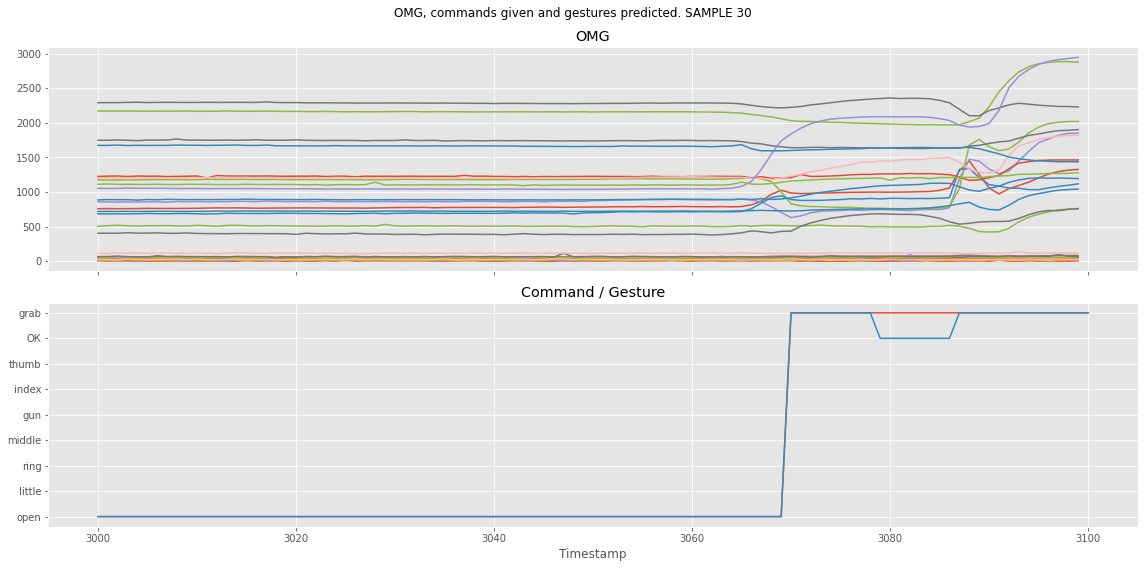

In [192]:
# Plot samples with errors (one at every cell execution) starting from the worst
i = next(deviations)
plot_omg_and_commands(X_flow.iloc[TICKS*i:TICKS*(i+1)], X_df.loc[TICKS*i:TICKS*(i+1), 'y'], 
                      X_df.loc[TICKS*i:TICKS*(i+1), 'predicted'], i=i)

### HYPERPARAMETERS FOR MAIN MODEL

Let's train the model at all data with hyperparameters selection by Optuna

In [201]:
scaler_main = MinMaxScaler()
X_scaled = scaler_main.fit_transform(np.vstack((X_train, X_val)))
pwn('X_scaled.shape')

y_target = np.concatenate((y_train_target, y_val_target))
pwn('y_target.shape')

Xopt=X_scaled
yopt=y_target
solvers_to_check = ['lbfgs']

study_lr3 = optuna.create_study(study_name="LogisticRegression3", direction="maximize")
study_lr3.optimize(optuna_lr1, n_trials=10)
print(f"Best hyperparameters: {study_lr3.best_params}")
print(f"f1_score at all data: {study_lr3.best_value:.6f}")

[I 2023-10-04 20:40:23,942] A new study created in memory with name: LogisticRegression3


X_scaled.shape = (32292, 200)
y_target.shape = (32292,)


[I 2023-10-04 20:40:36,362] Trial 0 finished with value: 0.9913783939844657 and parameters: {'solver': 'lbfgs', 'C': 0.5646900937524819}. Best is trial 0 with value: 0.9913783939844657.
[I 2023-10-04 20:41:11,790] Trial 1 finished with value: 0.9933387782555553 and parameters: {'solver': 'lbfgs', 'C': 54.86937643147957}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:41:18,196] Trial 2 finished with value: 0.9636467495224178 and parameters: {'solver': 'lbfgs', 'C': 0.011540016831616968}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:41:39,506] Trial 3 finished with value: 0.9931204150309249 and parameters: {'solver': 'lbfgs', 'C': 4.7082208984424465}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:41:45,293] Trial 4 finished with value: 0.9664081794092244 and parameters: {'solver': 'lbfgs', 'C': 0.012796285651293768}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:42:14,509] Trial 5 finished with value: 0.99327686

Best hyperparameters: {'solver': 'lbfgs', 'C': 54.86937643147957}
f1_score at all data: 0.993339


In [202]:
study_lr3.optimize(optuna_lr1, n_trials=10)
print(f"Best hyperparameters: {study_lr3.best_params}")
print(f"f1_score at all data: {study_lr3.best_value:.6f}")

[I 2023-10-04 20:43:47,445] Trial 10 finished with value: 0.9933081224292052 and parameters: {'solver': 'lbfgs', 'C': 72.30404991161964}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:44:17,900] Trial 11 finished with value: 0.9933077509362485 and parameters: {'solver': 'lbfgs', 'C': 49.08088304789609}. Best is trial 1 with value: 0.9933387782555553.
[I 2023-10-04 20:44:52,202] Trial 12 finished with value: 0.9933391818451293 and parameters: {'solver': 'lbfgs', 'C': 78.66094584840093}. Best is trial 12 with value: 0.9933391818451293.
[I 2023-10-04 20:45:17,149] Trial 13 finished with value: 0.9933386438293926 and parameters: {'solver': 'lbfgs', 'C': 13.09693319055635}. Best is trial 12 with value: 0.9933391818451293.
[I 2023-10-04 20:45:53,220] Trial 14 finished with value: 0.9932773969510286 and parameters: {'solver': 'lbfgs', 'C': 93.46712656180323}. Best is trial 12 with value: 0.9933391818451293.
[I 2023-10-04 20:46:18,317] Trial 15 finished with value: 0.9933074

Best hyperparameters: {'solver': 'lbfgs', 'C': 16.888794480220838}
f1_score at all data: 0.993369


Train a model with the best hyperparameters and save it.

In [210]:
lr_main = linear_model.LogisticRegression(**study_lr3.best_params, multi_class='multinomial', max_iter = 2000, random_state=42)
lr_main.fit(X_scaled, y_target)
y_pred = lr_main.predict(X_scaled)
print(metrics.classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18568
           1       1.00      1.00      1.00      1692
           2       1.00      1.00      1.00      1753
           3       1.00      1.00      1.00      1784
           4       1.00      1.00      1.00      1651
           5       1.00      1.00      1.00      1727
           6       1.00      1.00      1.00      1704
           7       1.00      1.00      1.00      1666
           8       1.00      1.00      1.00      1747

    accuracy                           1.00     32292
   macro avg       1.00      1.00      1.00     32292
weighted avg       1.00      1.00      1.00     32292



In [287]:
pwn('y_pred[y_target != y_pred].shape')

y_pred[y_target != y_pred].shape = (46,)


In [288]:
# Make pipeline from the main scaler and the main model, check it
pipeline = Pipeline([('sm', scaler_main), ('lm', lr_main)])
all(y_pred == pipeline.predict(np.vstack((X_train, X_val))))

True

In [221]:
# Save pipeline to use in production
with open('model/gesture_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

Finally, we have built the model that is able to predict the current gesture by a 5-timestamp window of OMG sensors with very high quality even in transit zones.